In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

## read flyai data for vision task

In [11]:
path_root = Path('../vision/StanfordDogs120_FlyAI/')
path_train = path_root/'data/local/train'
path_test = path_root/'data/local/test'
path_train.ls(),path_test.ls()

([PosixPath('../vision/StanfordDogs120_FlyAI/data/local/train/n02113799-standard_poodle'),
  PosixPath('../vision/StanfordDogs120_FlyAI/data/local/train/n02109961-Eskimo_dog'),
  PosixPath('../vision/StanfordDogs120_FlyAI/data/local/train/n02116738-African_hunting_dog'),
  PosixPath('../vision/StanfordDogs120_FlyAI/data/local/train/n02105251-briard'),
  PosixPath('../vision/StanfordDogs120_FlyAI/data/local/train/n02094433-Yorkshire_terrier'),
  PosixPath('../vision/StanfordDogs120_FlyAI/data/local/train/n02111277-Newfoundland'),
  PosixPath('../vision/StanfordDogs120_FlyAI/data/local/train/n02088466-bloodhound'),
  PosixPath('../vision/StanfordDogs120_FlyAI/data/local/train/n02095889-Sealyham_terrier'),
  PosixPath('../vision/StanfordDogs120_FlyAI/data/local/train/n02090721-Irish_wolfhound'),
  PosixPath('../vision/StanfordDogs120_FlyAI/data/local/train/n02109047-Great_Dane'),
  PosixPath('../vision/StanfordDogs120_FlyAI/data/local/train/n02085936-Maltese_dog'),
  PosixPath('../vision/

In [12]:
trn_csv = pd.read_csv(path_train/'train.csv')
val_csv = pd.read_csv(path_test/'test.csv')
trn_csv.head(),val_csv.head()

(                                    image_path  labels  \
 0  n02096437-Dandie_Dinmont/n02096437_1171.jpg      97   
 1    n02091244-Ibizan_hound/n02091244_3552.jpg       3   
 2       n02107142-Doberman/n02107142_13356.jpg      24   
 3      n02088466-bloodhound/n02088466_9576.jpg      94   
 4      n02112018-Pomeranian/n02112018_5738.jpg     114   
 
                        name  
 0  n02096437-Dandie_Dinmont  
 1    n02091244-Ibizan_hound  
 2        n02107142-Doberman  
 3      n02088466-bloodhound  
 4      n02112018-Pomeranian  ,
                                         image_path  labels  \
 0  n02091032-Italian_greyhound/n02091032_10314.jpg      78   
 1            n02110063-malamute/n02110063_9496.jpg      19   
 2     n02097474-Tibetan_terrier/n02097474_1763.jpg      58   
 3     n02106662-German_shepherd/n02106662_3260.jpg      27   
 4  n02099712-Labrador_retriever/n02099712_5000.jpg      79   
 
                            name  
 0   n02091032-Italian_greyhound  
 1     

In [13]:
data=ImageDataBunch.from_df(path=path_train,df=trn_csv,ds_tfms=get_transforms(),size=224,bs=64,valid_pct=0).normalize(imagenet_stats)
data_val=ImageDataBunch.from_df(path=path_test,df=val_csv,ds_tfms=get_transforms(),size=224,bs=64,valid_pct=0).normalize(imagenet_stats)
data.valid_dl= data_val.train_dl
data

ImageDataBunch;

Train: LabelList
y: CategoryList (12348 items)
[Category 97, Category 3, Category 24, Category 94, Category 114]...
Path: ../vision/StanfordDogs120_FlyAI/data/local/train
x: ImageItemList (12348 items)
[Image (3, 372, 500), Image (3, 300, 400), Image (3, 400, 400), Image (3, 333, 500), Image (3, 500, 375)]...
Path: ../vision/StanfordDogs120_FlyAI/data/local/train;

Valid: LabelList
y: CategoryList (4116 items)
[Category 78, Category 19, Category 58, Category 27, Category 79]...
Path: ../vision/StanfordDogs120_FlyAI/data/local/test
x: ImageItemList (4116 items)
[Image (3, 375, 500), Image (3, 500, 375), Image (3, 500, 388), Image (3, 375, 500), Image (3, 479, 500)]...
Path: ../vision/StanfordDogs120_FlyAI/data/local/test;

Test: None

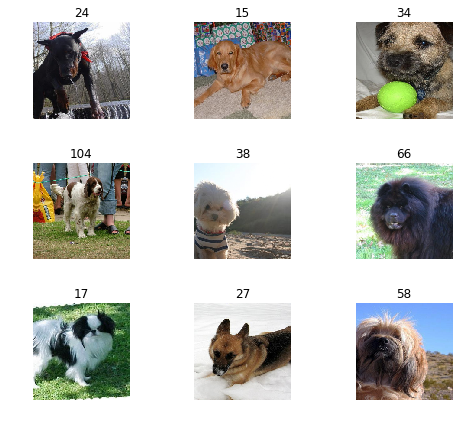

In [14]:
data.show_batch(rows=3,figsize=(7,6))

In [15]:
print(data.classes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]


In [7]:
@dataclass
class Fbeta_binary(Callback):
    "Computes the fbeta between preds and targets for single-label classification"
    beta2: int = 2
    eps: float = 1e-9
    clas:int=1
    
    def on_epoch_begin(self, **kwargs):
        self.TP = 0
        self.total_y_pred = 0   
        self.total_y_true = 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        y_pred = last_output.argmax(dim=1)
        y_true = last_target.float()
        
        self.TP += ((y_pred==self.clas) * (y_true==self.clas)).float().sum()
        self.total_y_pred += (y_pred==self.clas).float().sum()
        self.total_y_true += (y_true==self.clas).float().sum()
    
    def on_epoch_end(self, **kwargs):
        beta2=self.beta2**2
        prec = self.TP/(self.total_y_pred+self.eps)
        rec = self.TP/(self.total_y_true+self.eps)       
        res = (prec*rec)/(prec*beta2+rec+self.eps)*(1+beta2)
        self.metric = res

In [8]:
from learner import model_meta

In [9]:
model_meta

{<function torchvision.models.resnet.resnet18(pretrained=False, **kwargs)>: {'cut': -2,
  'split': <function learner._resnet_split(m:torch.nn.modules.module.Module)>},
 <function torchvision.models.resnet.resnet34(pretrained=False, **kwargs)>: {'cut': -2,
  'split': <function learner._resnet_split(m:torch.nn.modules.module.Module)>},
 <function torchvision.models.resnet.resnet50(pretrained=False, **kwargs)>: {'cut': -2,
  'split': <function learner._resnet_split(m:torch.nn.modules.module.Module)>},
 <function torchvision.models.resnet.resnet101(pretrained=False, **kwargs)>: {'cut': -2,
  'split': <function learner._resnet_split(m:torch.nn.modules.module.Module)>},
 <function torchvision.models.resnet.resnet152(pretrained=False, **kwargs)>: {'cut': -2,
  'split': <function learner._resnet_split(m:torch.nn.modules.module.Module)>},
 <function torchvision.models.squeezenet.squeezenet1_0(pretrained=False, **kwargs)>: {'cut': -1,
  'split': <function learner._squeezenet_split(m:torch.nn.mod

In [16]:
for m in list(model_meta.keys()):
    print(m)#learn = None
    try:
        gc.collect()
        torch.cuda.empty_cache()
        learn = create_cnn(data,m,metrics = [error_rate,accuracy, Fbeta_binary(beta2=1,clas = 1)])
        learn.fit_one_cycle(4)
    except:
        print('too many parameters')

<function resnet18 at 0x7f3e40812d90>


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary
1,2.084285,1.082970,0.313477,0.686523,0.690476
2,1.141942,0.808020,0.253906,0.746094,0.817204
3,0.850066,0.726928,0.225586,0.774414,0.808989
4,0.707707,0.711311,0.213135,0.786865,0.818182


<function resnet34 at 0x7f3e407a6268>


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary
1,1.757166,0.813067,0.226562,0.773438,0.838710
2,0.889068,0.615523,0.190674,0.809326,0.825000
3,0.642031,0.542781,0.165283,0.834717,0.886364
4,0.542255,0.525490,0.162354,0.837646,0.860465


<function resnet50 at 0x7f3e407a62f0>


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary
1,1.263048,0.637019,0.185059,0.814941,0.870588
2,0.726081,0.569727,0.175781,0.824219,0.900000
3,0.537633,0.463206,0.149414,0.850586,0.901099
4,0.386789,0.454807,0.136230,0.863770,0.896552


<function resnet101 at 0x7f3e407a6378>


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary
1,1.118876,0.551878,0.159912,0.840088,0.893617
2,0.620154,0.462499,0.141113,0.858887,0.893617
3,0.443762,0.404852,0.129150,0.870850,0.896552
4,0.319993,0.383320,0.120361,0.879639,0.888889


<function resnet152 at 0x7f3e407a6400>


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary


too many parameters
<function squeezenet1_0 at 0x7f3e407a6ae8>


/home/changebio/anaconda3/envs/fastv1/lib/python3.6/site-packages/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
/home/changebio/anaconda3/envs/fastv1/lib/python3.6/site-packages/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary
1,3.228815,2.204575,0.585938,0.414062,0.344828
2,2.024691,1.587687,0.443359,0.556641,0.417910
3,1.639182,1.377338,0.395996,0.604004,0.561798
4,1.388414,1.344956,0.384766,0.615234,0.606742


<function squeezenet1_1 at 0x7f3e407a6d90>


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary
1,3.138080,2.112655,0.547607,0.452393,0.415842
2,1.968602,1.543800,0.440674,0.559326,0.576923
3,1.585287,1.380050,0.407959,0.592041,0.528736
4,1.398661,1.340433,0.389160,0.610840,0.558140


<function densenet121 at 0x7f3e407b2bf8>


/home/changebio/anaconda3/envs/fastv1/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary
1,1.777671,0.856025,0.249756,0.750244,0.769231
2,0.887653,0.666031,0.211182,0.788818,0.808081
3,0.631778,0.560818,0.171875,0.828125,0.827586
4,0.464968,0.524049,0.158936,0.841064,0.827586


<function densenet169 at 0x7f3e407b2c80>


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary


too many parameters
<function densenet201 at 0x7f3e407b2d08>


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary


too many parameters
<function densenet161 at 0x7f3e407b2d90>


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary


too many parameters
<function vgg16_bn at 0x7f3e407a6950>


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary
1,2.192457,1.082956,0.298584,0.701416,0.639344
2,1.046461,0.759309,0.233887,0.766113,0.767442
3,0.815440,0.650280,0.195068,0.804932,0.804348
4,0.649534,0.627006,0.192383,0.807617,0.808989


<function vgg19_bn at 0x7f3e407a6a60>


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary
1,1.994091,0.945650,0.259277,0.740723,0.750000
2,1.001434,0.683793,0.210205,0.789795,0.850000
3,0.723194,0.596693,0.181396,0.818604,0.880952
4,0.609926,0.583639,0.170410,0.829590,0.869565


<function alexnet at 0x7f3e408128c8>


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary
1,3.419096,2.367417,0.597412,0.402588,0.421053
2,2.277367,1.808596,0.496338,0.503662,0.478873
3,1.928254,1.660954,0.460205,0.539795,0.597938
4,1.777908,1.631737,0.460205,0.539795,0.606742


In [17]:
from scipy.io import wavfile

In [18]:
sr,y = wavfile.read("../speech/UrbanSoundClassification_FlyAI/data/input/wav/104.wav",)

In [22]:
?wavfile.read

In [23]:
for m in list(model_meta.keys())[5:]:
    #learn = None
    torch.cuda.empty_cache()
    learn = create_cnn(data,m,metrics = [error_rate,accuracy, Fbeta_binary(beta2=1,clas = 1)])
    res=learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary
1,0.226623,0.187498,0.067769,0.932231,0.929715
2,0.215413,0.167546,0.060683,0.939317,0.938399
3,0.174425,0.161622,0.060138,0.939862,0.938373
4,0.181529,0.159999,0.055778,0.944222,0.942905


Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /home/changebio/.torch/models/squeezenet1_1-f364aa15.pth
100%|██████████| 4966400/4966400 [00:03<00:00, 1387441.76it/s]


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary
1,0.235650,0.192989,0.065225,0.934775,0.932251
2,0.181064,0.162079,0.058866,0.941134,0.939303
3,0.182070,0.155746,0.055959,0.944041,0.942857
4,0.176380,0.159411,0.058321,0.941679,0.939008


/home/changebio/anaconda3/envs/fastv1/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary
1,0.202340,0.157076,0.051054,0.948946,0.947799
2,0.156629,0.136281,0.048874,0.951126,0.950065
3,0.134919,0.122245,0.045422,0.954578,0.953306
4,0.117643,0.115205,0.042696,0.957304,0.956376


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary


RuntimeError: CUDA out of memory. Tried to allocate 117.50 MiB (GPU 0; 10.91 GiB total capacity; 9.21 GiB already allocated; 142.06 MiB free; 29.96 MiB cached)

In [13]:
list(model_meta.keys())

[<function torchvision.models.resnet.resnet18(pretrained=False, **kwargs)>,
 <function torchvision.models.resnet.resnet34(pretrained=False, **kwargs)>,
 <function torchvision.models.resnet.resnet50(pretrained=False, **kwargs)>,
 <function torchvision.models.resnet.resnet101(pretrained=False, **kwargs)>,
 <function torchvision.models.resnet.resnet152(pretrained=False, **kwargs)>,
 <function torchvision.models.squeezenet.squeezenet1_0(pretrained=False, **kwargs)>,
 <function torchvision.models.squeezenet.squeezenet1_1(pretrained=False, **kwargs)>,
 <function torchvision.models.densenet.densenet121(pretrained=False, **kwargs)>,
 <function torchvision.models.densenet.densenet169(pretrained=False, **kwargs)>,
 <function torchvision.models.densenet.densenet201(pretrained=False, **kwargs)>,
 <function torchvision.models.densenet.densenet161(pretrained=False, **kwargs)>,
 <function torchvision.models.vgg.vgg16_bn(pretrained=False, **kwargs)>,
 <function torchvision.models.vgg.vgg19_bn(pretrain

In [17]:
for m in model_meta.keys():
    learn = create_cnn(data,m,metrics = [error_rate,accuracy, Fbeta_binary(beta2=1,clas = 1)])
    res=learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary
1,0.259443,0.206021,0.074491,0.925509,0.924214
2,0.187036,0.163220,0.058866,0.941134,0.939866
3,0.176926,0.143175,0.051054,0.948946,0.948126
4,0.133450,0.135708,0.049237,0.950763,0.949355


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary
1,0.246255,0.188738,0.069404,0.930596,0.929364
2,0.172432,0.143756,0.050690,0.949310,0.948074
3,0.153237,0.136594,0.050690,0.949310,0.948016
4,0.141645,0.138862,0.051235,0.948765,0.946893


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary
1,0.214714,0.164862,0.058140,0.941860,0.940454
2,0.165523,0.138334,0.050327,0.949673,0.948484
3,0.135429,0.127762,0.045422,0.954578,0.953428
4,0.129969,0.124768,0.046693,0.953307,0.951864


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/changebio/.torch/models/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [02:39<00:00, 1123626.88it/s]


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary


RuntimeError: CUDA out of memory. Tried to allocate 49.00 MiB (GPU 0; 10.91 GiB total capacity; 5.49 GiB already allocated; 32.81 MiB free; 153.73 MiB cached)

In [12]:
for i in model_type

In [53]:
learn.save('stage-1')

In [54]:
interp = ClassificationInterpretation.from_learner(learn)

In [56]:
losses,idxs = interp.top_losses()
len(data.valid_ds),len(losses),len(idxs)

(5512, 5504, 5504)

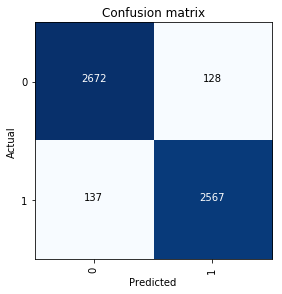

In [58]:
interp.plot_confusion_matrix()

In [59]:
learn.unfreeze()

In [60]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.141186,0.116783,0.039426


In [61]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


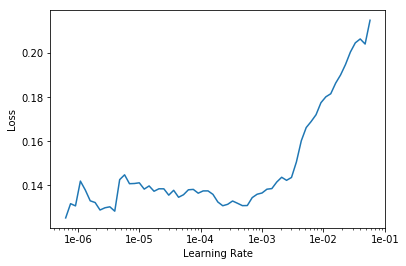

In [62]:
learn.recorder.plot()

In [63]:
learn.unfreeze()
learn.fit_one_cycle(2,max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.118870,0.104693,0.037427
2,0.108816,0.105676,0.039426


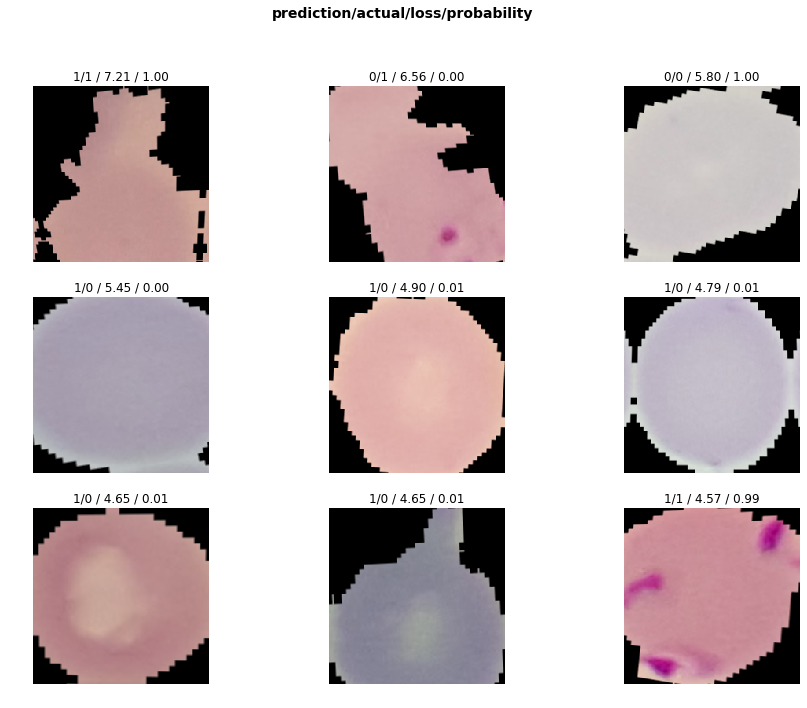

In [57]:
interp.plot_top_losses(9,figsize=(15,11))

In [ ]:
from torch.utils.data.dataset import Dataset
from torchvision import transforms

class MyCustomDataset(Dataset):
    def __init__(self, ..., transforms=None):
        # stuff
        ...
        self.transforms = transforms
        
    def __getitem__(self, index):
        # stuff
        ...
        data = # Some data read from a file or image
        if self.transforms is not None:
            data = self.transforms(data)
        # If the transform variable is not empty
        # then it applies the operations in the transforms with the order that it is created.
        return (img, label)

    def __len__(self):
        return count # of how many data(images?) you have
    
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
])
dataset = ImdbWikiDataset(transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=1)

In [43]:
data.valid_ds

LabelList
y: CategoryList (5512 items)
[Category 0, Category 1, Category 1, Category 0, Category 1]...
Path: ../vision/MalariaCellImages_FlyAI/data/local/test
x: ImageItemList (5512 items)
[Image (3, 103, 145), Image (3, 151, 136), Image (3, 127, 118), Image (3, 148, 127), Image (3, 118, 103)]...
Path: ../vision/MalariaCellImages_FlyAI/data/local/test

In [28]:
?DataLoader

In [24]:
data.valid_ds

LabelList
y: CategoryList (3306 items)
[Category 0, Category 0, Category 0, Category 1, Category 0]...
Path: ../vision/MalariaCellImages_FlyAI/data/local/train
x: ImageItemList (3306 items)
[Image (3, 154, 124), Image (3, 124, 109), Image (3, 127, 112), Image (3, 148, 148), Image (3, 109, 106)]...
Path: ../vision/MalariaCellImages_FlyAI/data/local/train

In [20]:
?ImageDataBunch.from_df